In [ ]:
# %%time

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving test_pFkWwen.csv to test_pFkWwen.csv
Saving train_yaOffsB.csv to train_yaOffsB.csv
User uploaded file "test_pFkWwen.csv" with length 1881912 bytes
User uploaded file "train_yaOffsB.csv" with length 2997136 bytes
CPU times: user 884 ms, sys: 126 ms, total: 1.01 s
Wall time: 2min 4s


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/train_yaOffsB.csv')
test = pd.read_csv('/content/test_pFkWwen.csv')

# sample_submission = pd.read_csv('/content/sample_submission_V9Inaty.csv.csv')
print('Train shape:{}'.format(train.shape))
print('Test shape:{}'.format(test.shape))

Train shape:(88858, 10)
Test shape:(59310, 9)


In [ ]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [ ]:
train['Crop_Damage'].value_counts()

0    74238
1    12307
2     2313
Name: Crop_Damage, dtype: int64

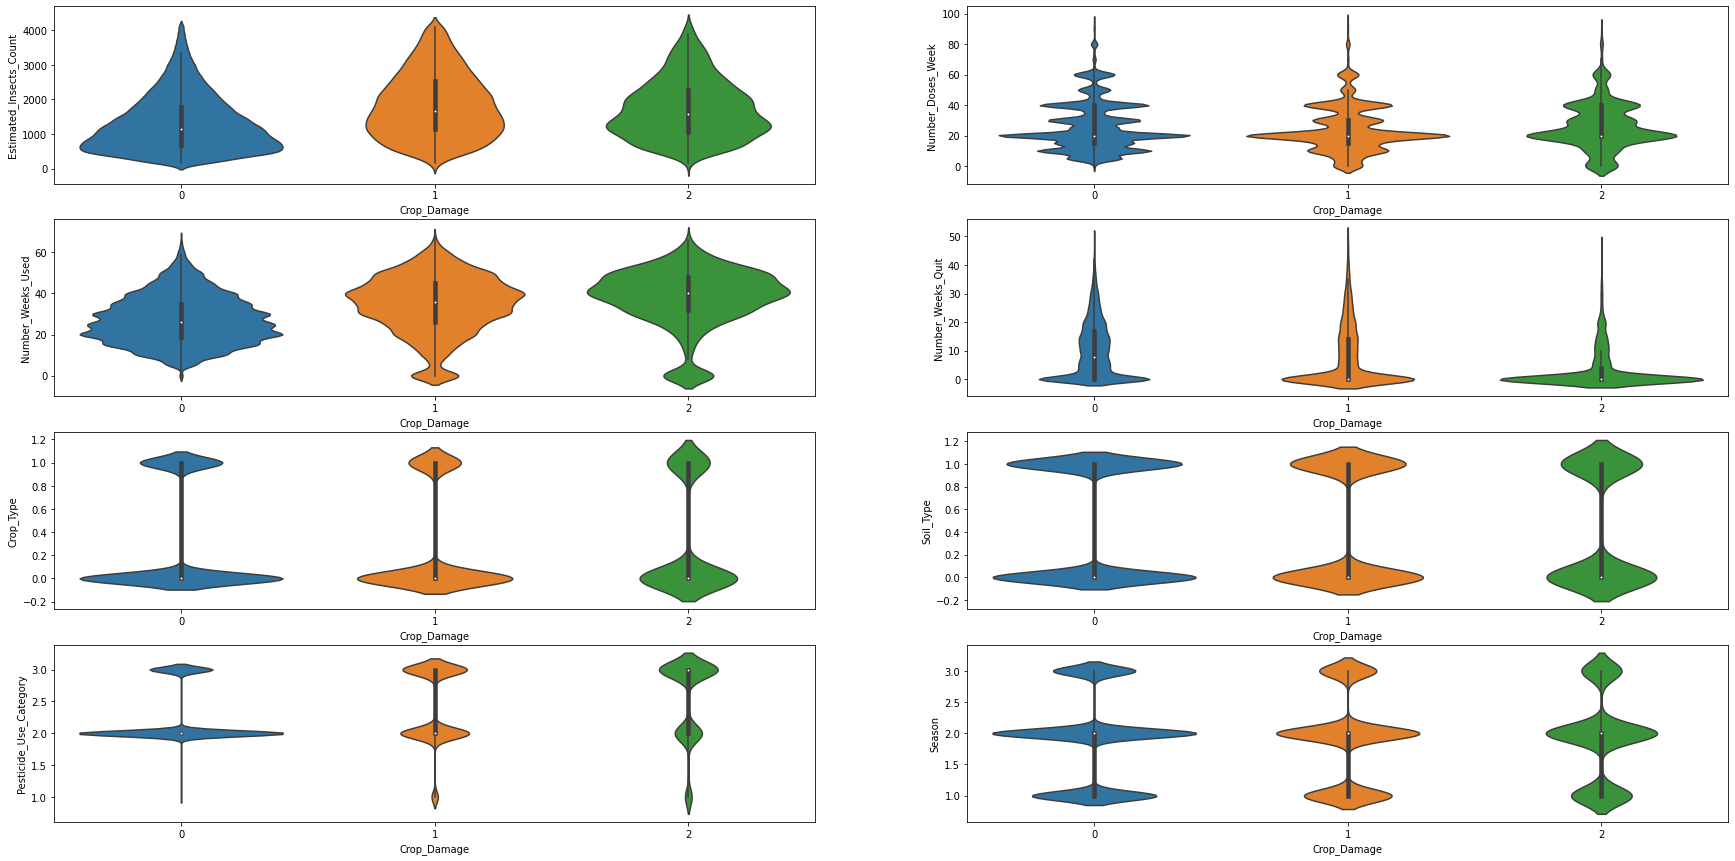

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(30,15))

cols_to_plot = ['Estimated_Insects_Count', 'Number_Doses_Week',
                'Number_Weeks_Used', 'Number_Weeks_Quit', 'Crop_Type',
                'Soil_Type', 'Pesticide_Use_Category', 'Season']

for i in range(0, len(cols_to_plot)):
  sns.violinplot(x=train['Crop_Damage'], y=train[cols_to_plot[i]], ax=ax[int(i/2)][i%2])

In [ ]:
train.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

In [ ]:
train.loc[train['Number_Doses_Week']==0,'Number_Weeks_Used'] = 0

In [ ]:
train['Number_Weeks_Used'].fillna(np.mean(train['Number_Weeks_Used']), inplace=True)

In [ ]:
train.isnull().sum()

ID                         0
Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
dtype: int64

# Feature Engineering

In [ ]:
train['source'] = 'train'
test['source'] = 'test'

unified = pd.concat([train, test], axis=0)
unified.shape

(148168, 11)

In [ ]:
unified.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,source
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,train
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,train
2,F00000004,257,1,0,1,0,0.0,0,2,1.0,train
3,F00000005,257,1,1,1,0,0.0,0,2,1.0,train
4,F00000006,342,1,0,1,0,0.0,0,2,1.0,train


## Ratio of variables to determine per unit metrics

In [ ]:
unified['usage_insects'] = unified['Estimated_Insects_Count']/unified['Number_Weeks_Used']
unified.loc[unified['usage_insects'].isin([np.nan, np.inf, -np.inf]), 'usage_insects'] = 0

In [ ]:
unified['wks_used_to_quit'] = unified['Number_Weeks_Used']/unified['Number_Weeks_Quit']
unified.loc[unified['wks_used_to_quit'].isin([np.nan, np.inf, -np.inf]), 'wks_used_to_quit'] = 0

In [ ]:
unified.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,source,usage_insects,wks_used_to_quit
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,train,0.0,0.0
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,train,0.0,0.0
2,F00000004,257,1,0,1,0,0.0,0,2,1.0,train,0.0,0.0
3,F00000005,257,1,1,1,0,0.0,0,2,1.0,train,0.0,0.0
4,F00000006,342,1,0,1,0,0.0,0,2,1.0,train,0.0,0.0


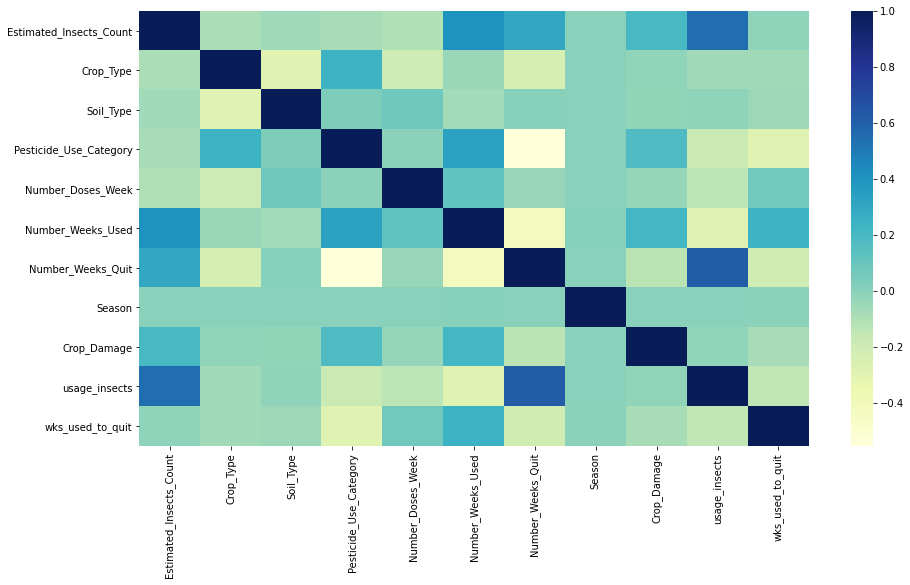

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

tmp = unified[unified['source']=='train']
cr = tmp.corr()
sns.heatmap(cr, cmap='YlGnBu')

## Compute stats of continuous variables based on categorical variables

In [ ]:
def multiple_aggregations(df, cat_vars, con_vars, suffix):
  tmp = df.groupby([cat_vars]).agg({con_vars:[np.mean, np.std, min, max]}).\
                                    reset_index()
  tmp.columns = ['_'.join(col).strip() for col in tmp.columns.values]
  tmp.columns = [str(c) + '_' + str(suffix) for c in tmp.columns]
  tmp.columns.values[0] = cat_vars
  
  df = pd.merge(df, tmp, on=[cat_vars], how='left')
  return df

In [ ]:
train = unified[unified['source']=='train']
test = unified[unified['source']=='test']

con_var = ['Estimated_Insects_Count', 'Number_Doses_Week',
           'Number_Weeks_Used', 'Number_Weeks_Quit']


for con in con_var:
  train = multiple_aggregations(train, 'Crop_Type', con, 'crop')
  train = multiple_aggregations(train, 'Soil_Type', con, 'soil')
  train = multiple_aggregations(train, 'Pesticide_Use_Category', con, 'pest')
  train = multiple_aggregations(train, 'Season', con, 'ssn')

  test = multiple_aggregations(test, 'Crop_Type', con, 'crop')
  test = multiple_aggregations(test, 'Soil_Type', con, 'soil')
  test = multiple_aggregations(test, 'Pesticide_Use_Category', con, 'pest')
  test = multiple_aggregations(test, 'Season', con, 'ssn')


train.drop(['source'], axis=1, inplace=True)
test.drop(['source'], axis=1, inplace=True)

### Compute total dosage and avg.dosage through duration of harvest

In [ ]:
# # Didnt work

# train['total_dosage'] = train['Number_Doses_Week'] * train['Number_Weeks_Used']
# train['total_wks_harvest'] = train['Number_Weeks_Used'] + train['Number_Weeks_Quit']
# train['avg_dosage_harvest'] = train['total_dosage']/train['total_wks_harvest']
# train['dosage_per_insect'] = train['total_dosage']/train['Estimated_Insects_Count']

# test['total_dosage'] = test['Number_Doses_Week'] * test['Number_Weeks_Used']
# test['total_wks_harvest'] = test['Number_Weeks_Used'] + test['Number_Weeks_Quit']
# test['avg_dosage_harvest'] = test['total_dosage']/test['total_wks_harvest']
# test['dosage_per_insect'] = test['total_dosage']/test['Estimated_Insects_Count']

# train.loc[train['total_dosage'].isin([np.nan, np.inf, -np.inf]), 'total_dosage'] = 0
# train.loc[train['total_wks_harvest'].isin([np.nan, np.inf, -np.inf]), 'total_wks_harvest'] = 0
# train.loc[train['avg_dosage_harvest'].isin([np.nan, np.inf, -np.inf]), 'avg_dosage_harvest'] = 0
# train.loc[train['dosage_per_insect'].isin([np.nan, np.inf, -np.inf]), 'dosage_per_insect'] = 0

# test.loc[test['total_dosage'].isin([np.nan, np.inf, -np.inf]), 'total_dosage'] = 0
# test.loc[test['total_wks_harvest'].isin([np.nan, np.inf, -np.inf]), 'total_wks_harvest'] = 0
# test.loc[test['avg_dosage_harvest'].isin([np.nan, np.inf, -np.inf]), 'avg_dosage_harvest'] = 0
# test.loc[test['dosage_per_insect'].isin([np.nan, np.inf, -np.inf]), 'dosage_per_insect'] = 0

# train.drop(['total_wks_harvest'], axis=1, inplace=True)
# test.drop(['total_wks_harvest'], axis=1, inplace=True)

In [ ]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,usage_insects,wks_used_to_quit,Estimated_Insects_Count_mean_crop,Estimated_Insects_Count_std_crop,Estimated_Insects_Count_min_crop,Estimated_Insects_Count_max_crop,Estimated_Insects_Count_mean_soil,Estimated_Insects_Count_std_soil,Estimated_Insects_Count_min_soil,Estimated_Insects_Count_max_soil,Estimated_Insects_Count_mean_pest,Estimated_Insects_Count_std_pest,Estimated_Insects_Count_min_pest,Estimated_Insects_Count_max_pest,Estimated_Insects_Count_mean_ssn,Estimated_Insects_Count_std_ssn,Estimated_Insects_Count_min_ssn,Estimated_Insects_Count_max_ssn,Number_Doses_Week_mean_crop,Number_Doses_Week_std_crop,Number_Doses_Week_min_crop,Number_Doses_Week_max_crop,Number_Doses_Week_mean_soil,Number_Doses_Week_std_soil,Number_Doses_Week_min_soil,Number_Doses_Week_max_soil,Number_Doses_Week_mean_pest,Number_Doses_Week_std_pest,Number_Doses_Week_min_pest,Number_Doses_Week_max_pest,Number_Doses_Week_mean_ssn,Number_Doses_Week_std_ssn,Number_Doses_Week_min_ssn,Number_Doses_Week_max_ssn,Number_Weeks_Used_mean_crop,Number_Weeks_Used_std_crop,Number_Weeks_Used_min_crop,Number_Weeks_Used_max_crop,Number_Weeks_Used_mean_soil,Number_Weeks_Used_std_soil,Number_Weeks_Used_min_soil,Number_Weeks_Used_max_soil,Number_Weeks_Used_mean_pest,Number_Weeks_Used_std_pest,Number_Weeks_Used_min_pest,Number_Weeks_Used_max_pest,Number_Weeks_Used_mean_ssn,Number_Weeks_Used_std_ssn,Number_Weeks_Used_min_ssn,Number_Weeks_Used_max_ssn,Number_Weeks_Quit_mean_crop,Number_Weeks_Quit_std_crop,Number_Weeks_Quit_min_crop,Number_Weeks_Quit_max_crop,Number_Weeks_Quit_mean_soil,Number_Weeks_Quit_std_soil,Number_Weeks_Quit_min_soil,Number_Weeks_Quit_max_soil,Number_Weeks_Quit_mean_pest,Number_Weeks_Quit_std_pest,Number_Weeks_Quit_min_pest,Number_Weeks_Quit_max_pest,Number_Weeks_Quit_mean_ssn,Number_Weeks_Quit_std_ssn,Number_Weeks_Quit_min_ssn,Number_Weeks_Quit_max_ssn
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1394.991673,853.620148,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0.0,0,0,25.881719,15.610313,0,95,27.782579,12.131219,0.0,67.0,29.308552,11.929009,0.0,67.0,0.0,0.0,0.0,0.0,28.489250,11.80114,0.0,67.0,5.924374,8.321529,0,50,9.504696,9.773190,0,50,0.0,0.0,0,0,9.600810,9.926603,0,50
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0.0,0,0,25.842004,15.594075,0,95,27.782579,12.131219,0.0,67.0,29.308552,11.929009,0.0,67.0,0.0,0.0,0.0,0.0,28.638378,11.81034,0.0,67.0,5.924374,8.321529,0,50,9.504696,9.773190,0,50,0.0,0.0,0,0,9.568514,9.860688,0,50
2,F00000004,257,1,0,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0.0,0,0,25.842004,15.594075,0,95,27.782579,12.131219,0.0,67.0,29.308552,11.929009,0.0,67.0,0.0,0.0,0.0,0.0,28.638378,11.81034,0.0,67.0,5.924374,8.321529,0,50,9.504696,9.773190,0,50,0.0,0.0,0,0,9.568514,9.860688,0,50
3,F00000005,257,1,1,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1346.986203,831.661814,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,27.193131,15.984844,0,95,0.0,0.0,0,0,25.842004,15.594075,0,95,27.782579,12.131219,0.0,67.0,27.739438,11.556327,0.0,67.0,0.0,0.0,0.0,0.0,28.638378,11.81034,0.0,67.0,5.924374,8.321529,0,50,9.690750,10.048298,0,50,0.0,0.0,0,0,9.568514,9.860688,0,50
4,F00000006,342,1,0,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0

In [ ]:
train.shape

(88858, 76)

# Model

In [ ]:
kf = KFold(n_splits=5, random_state=55)
skf = StratifiedKFold(n_splits=5, random_state=55)


xgb_params = {
      'objective' : 'multi:softmax'
    , 'booster' : 'gbtree'
    , 'eta' : 0.01
    , 'max_depth' : 6
    , 'subsample' : 0.7
    , 'colsample_bytree' : 0.7
    , 'eval_metric' : 'merror'
    , 'seed' : 67
    , 'num_class' : 3
}

X = train.copy()
y = train['Crop_Damage']
X.drop(['Crop_Damage', 'ID'], inplace=True, axis=1)

****************************************
Iteration #:1
[0]	dval-merror:0.160027
Will train until dval-merror hasn't improved in 200 rounds.
[50]	dval-merror:0.159352
[100]	dval-merror:0.156313
[150]	dval-merror:0.155976
[200]	dval-merror:0.156144
[250]	dval-merror:0.155357
[300]	dval-merror:0.155019
[350]	dval-merror:0.154682
[400]	dval-merror:0.15485
[450]	dval-merror:0.154231
[500]	dval-merror:0.153781
[550]	dval-merror:0.152937
[600]	dval-merror:0.152543
[650]	dval-merror:0.152206
[700]	dval-merror:0.152037
[750]	dval-merror:0.152262
[800]	dval-merror:0.152262
[850]	dval-merror:0.152206
[900]	dval-merror:0.151981
[950]	dval-merror:0.151924
[1000]	dval-merror:0.151924
[1050]	dval-merror:0.151643
[1100]	dval-merror:0.151474
[1150]	dval-merror:0.151362
[1200]	dval-merror:0.151418
[1250]	dval-merror:0.151474
[1300]	dval-merror:0.151643
Stopping. Best iteration:
[1137]	dval-merror:0.151362

****************************************
Iteration #:2
[0]	dval-merror:0.159352
Will train until d

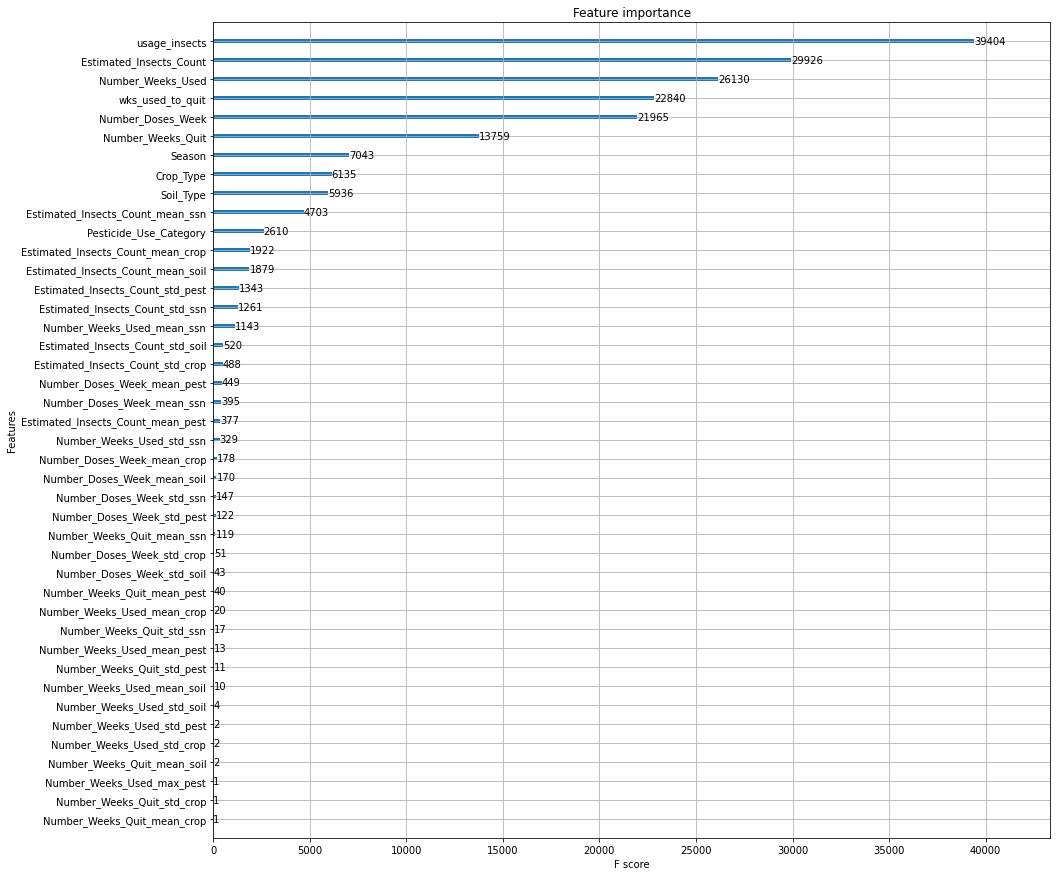

In [ ]:
%%time

pred_X = pd.DataFrame()
pred_y = pd.DataFrame()

for idx, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
  print('**'*20)
  print('Iteration #:{}'.format(idx+1))

  X_tr, X_val, y_tr, y_val = X.iloc[tr_idx], X.iloc[val_idx],\
                              y.iloc[tr_idx], y.iloc[val_idx]

  dtrain = xgb.DMatrix(X_tr, label=y_tr)
  dval = xgb.DMatrix(X_val, label=y_val)  

  model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=5000,
                    evals=[(dval, 'dval')], early_stopping_rounds=200,
                    verbose_eval=50)
  
  pred_X = pd.concat([pred_X, X_val], axis=0)
  pred_y = pd.concat([pred_y, y_val], axis=0)
  
fig, ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(model, ax=ax, height=0.2)

In [ ]:
preds = pd.DataFrame(model.predict(xgb.DMatrix(pred_X)), columns=['predicted'])
preds = pd.concat([preds, pred_y], axis=1)
preds.columns.values[-1] = 'actual'
preds.head()

,predicted,actual
0,1.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [ ]:
preds = pd.concat([train, preds], axis=1)
preds.to_csv('debug_07262020.csv', index=False)
preds.shape

(88858, 78)

In [ ]:
accuracy_score(preds['predicted'], preds['actual'])

0.8508744288640302

In [ ]:
tmp = test.copy()
tmp = tmp.drop(['ID', 'Crop_Damage'], axis=1)
submit = pd.DataFrame(model.predict(xgb.DMatrix(tmp)))
submit = pd.concat([test['ID'],submit], axis=1)
submit.columns.values[-1] = 'Crop_Damage'

print(submit.head())
print(submit['Crop_Damage'].value_counts())

submit.to_csv('harvest_wks_xgb_07262020.csv', index=False)

          ID  Crop_Damage
0  F00000002          1.0
1  F00000007          1.0
2  F00000011          1.0
3  F00000013          1.0
4  F00000014          1.0
0.0    56540
1.0     2760
2.0       10
Name: Crop_Damage, dtype: int64


## Feature Selection based on Feature importance

In [ ]:
sorted(model.get_fscore().items(), key=lambda x: x[1], reverse=True)

[('usage_insects', 41214),
 ('Estimated_Insects_Count', 30853),
 ('Number_Weeks_Used', 26629),
 ('Number_Doses_Week', 24410),
 ('wks_used_to_quit', 22653),
 ('Number_Weeks_Quit', 13987),
 ('Season', 6947),
 ('Crop_Type', 6523),
 ('Soil_Type', 6012),
 ('Estimated_Insects_Count_mean_ssn', 4344),
 ('Pesticide_Use_Category', 2585),
 ('Estimated_Insects_Count_std_pest', 1500),
 ('Estimated_Insects_Count_mean_soil', 1273),
 ('Estimated_Insects_Count_mean_crop', 1254),
 ('Estimated_Insects_Count_std_ssn', 800),
 ('Number_Weeks_Used_mean_ssn', 766),
 ('Number_Doses_Week_mean_pest', 306),
 ('Estimated_Insects_Count_std_soil', 233),
 ('Estimated_Insects_Count_mean_pest', 215),
 ('Estimated_Insects_Count_std_crop', 194),
 ('Number_Doses_Week_mean_ssn', 174),
 ('Number_Weeks_Used_std_ssn', 127),
 ('Number_Doses_Week_std_pest', 62),
 ('Number_Doses_Week_mean_soil', 46),
 ('Number_Doses_Week_mean_crop', 45),
 ('Number_Weeks_Quit_mean_ssn', 28),
 ('Number_Doses_Week_std_ssn', 28),
 ('Number_Weeks_Qui

In [ ]:
thresh = 500

shortlisted_features = []
for k, v in model.get_fscore().items():
  if v > thresh:
    shortlisted_features.append(k)
  else:
    print('Omitting feature {} as importance is {}'.format(k,v))
    pass

Omitting feature Estimated_Insects_Count_std_crop as importance is 194
Omitting feature Number_Doses_Week_mean_pest as importance is 306
Omitting feature Number_Doses_Week_std_pest as importance is 62
Omitting feature Estimated_Insects_Count_std_soil as importance is 233
Omitting feature Number_Doses_Week_mean_soil as importance is 46
Omitting feature Number_Weeks_Quit_mean_pest as importance is 10
Omitting feature Number_Weeks_Quit_mean_ssn as importance is 28
Omitting feature Number_Doses_Week_mean_ssn as importance is 174
Omitting feature Number_Doses_Week_std_ssn as importance is 28
Omitting feature Number_Doses_Week_mean_crop as importance is 45
Omitting feature Number_Weeks_Used_std_ssn as importance is 127
Omitting feature Estimated_Insects_Count_mean_pest as importance is 215
Omitting feature Number_Weeks_Quit_std_ssn as importance is 2
Omitting feature Number_Weeks_Quit_std_pest as importance is 3
Omitting feature Number_Doses_Week_std_crop as importance is 5
Omitting feature 

In [ ]:
train.shape

(88858, 76)

In [ ]:
kf = KFold(n_splits=5, random_state=55)
skf = StratifiedKFold(n_splits=5, random_state=55)


xgb_params = {
      'objective' : 'multi:softmax'
    , 'booster' : 'gbtree'
    , 'eta' : 0.01
    , 'max_depth' : 6
    , 'subsample' : 0.8
    , 'colsample_bytree' : 0.8
    , 'eval_metric' : 'merror'
    , 'seed' : 67
    , 'num_class' : 3
}

X = train.copy()
y = train['Crop_Damage']
X.drop(['Crop_Damage', 'ID'], inplace=True, axis=1)
X = X[shortlisted_features]
print(X.shape)

(88858, 16)


****************************************
Iteration #:1
[0]	dval-merror:0.156482
Will train until dval-merror hasn't improved in 200 rounds.
[50]	dval-merror:0.159521
[100]	dval-merror:0.156651
[150]	dval-merror:0.155976
[200]	dval-merror:0.155919
[250]	dval-merror:0.155188
[300]	dval-merror:0.15485
[350]	dval-merror:0.15485
[400]	dval-merror:0.15485
[450]	dval-merror:0.154231
[500]	dval-merror:0.153669
[550]	dval-merror:0.153331
[600]	dval-merror:0.152881
[650]	dval-merror:0.1526
[700]	dval-merror:0.152487
[750]	dval-merror:0.152037
[800]	dval-merror:0.151981
[850]	dval-merror:0.152037
[900]	dval-merror:0.151868
[950]	dval-merror:0.151812
[1000]	dval-merror:0.151868
[1050]	dval-merror:0.151756
[1100]	dval-merror:0.151812
[1150]	dval-merror:0.151812
[1200]	dval-merror:0.151812
Stopping. Best iteration:
[1001]	dval-merror:0.151699

****************************************
Iteration #:2
[0]	dval-merror:0.155582
Will train until dval-merror hasn't improved in 200 rounds.
[50]	dval-merror:0

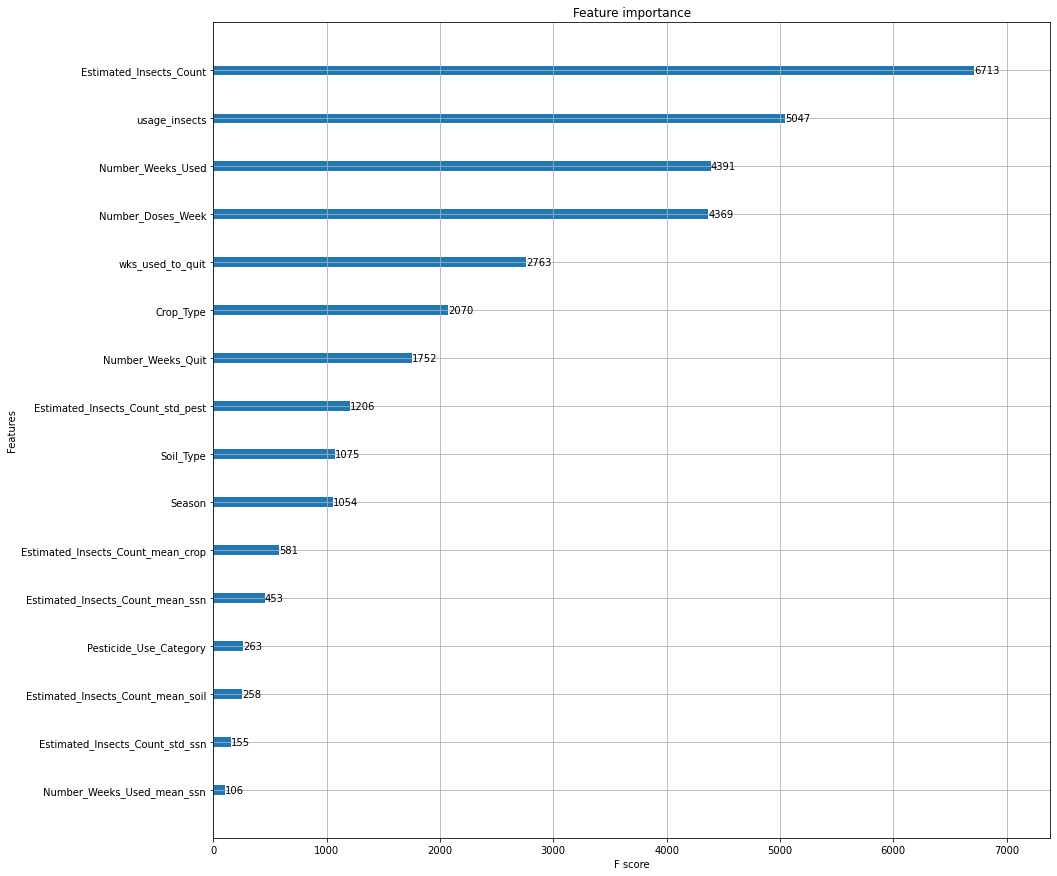

In [ ]:
%%time

pred_X = pd.DataFrame()
pred_y = pd.DataFrame()

for idx, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
  print('**'*20)
  print('Iteration #:{}'.format(idx+1))

  X_tr, X_val, y_tr, y_val = X.iloc[tr_idx], X.iloc[val_idx],\
                              y.iloc[tr_idx], y.iloc[val_idx]

  dtrain = xgb.DMatrix(X_tr, label=y_tr)
  dval = xgb.DMatrix(X_val, label=y_val)  

  model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=5000,
                    evals=[(dval, 'dval')], early_stopping_rounds=200,
                    verbose_eval=50)
  
  pred_X = pd.concat([pred_X, X_val], axis=0)
  pred_y = pd.concat([pred_y, y_val], axis=0)
  
fig, ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(model, ax=ax, height=0.2)

In [ ]:
preds = pd.DataFrame(model.predict(xgb.DMatrix(pred_X)), columns=['predicted'])
preds = pd.concat([preds, pred_y], axis=1)
preds.columns.values[-1] = 'actual'
preds.head()

,predicted,actual
0,1.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [ ]:
preds = pd.concat([train, preds], axis=1)
preds.to_csv('debug_07262020.csv', index=False)
preds.shape

(88858, 78)

In [ ]:
accuracy_score(preds['predicted'], preds['actual'])

0.8432217695649238

In [ ]:
tmp = test.copy()
tmp = tmp[shortlisted_features]
submit = pd.DataFrame(model.predict(xgb.DMatrix(tmp)))
submit = pd.concat([test['ID'],submit], axis=1)
submit.columns.values[-1] = 'Crop_Damage'

print(submit.head())
print(submit['Crop_Damage'].value_counts())

submit.to_csv('harvest_wks_xgb_07262020.csv', index=False)

          ID  Crop_Damage
0  F00000002          1.0
1  F00000007          1.0
2  F00000011          1.0
3  F00000013          1.0
4  F00000014          1.0
0.0    57885
1.0     1425
Name: Crop_Damage, dtype: int64


## Hyperparameter optimization

In [ ]:
kf = KFold(n_splits=5, random_state=55)

xgb_params = {
      'objective' : 'multi:softmax'
    , 'booster' : 'gbtree'
    , 'eta' : 0.1
    , 'max_depth' : 6
    , 'subsample' : 0.8
    , 'colsample_bytree' : 0.8
    , 'eval_metric' : 'merror'
    , 'seed' : 67
    , 'num_class' : 3
}

X = train.copy()
y = train['Crop_Damage']
X.drop(['Crop_Damage', 'ID'], inplace=True, axis=1)

In [ ]:
# xgb = XGBClassifier()
# optimization_dict = {'max_depth': [5,6,8,9],
#                      'eta': [0.01, 0.1, 0.2, 0.3]}

# model = GridSearchCV(xgb, optimization_dict, 
#                      scoring='accuracy', verbose=1)

# model.fit(X, y)
# print(model.best_score_)
# print(model.best_params_)

# RESULT:

# Fitting 5 folds for each of 16 candidates, totalling 80 fits

# [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
# [Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 103.5min finished

# 0.8470593441433543
# {'eta': 0.01, 'max_depth': 6}